<a href="https://colab.research.google.com/github/scharu07/Rossmann_Sales-Prediction-Capstone-Project/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## <u>**Importing**</u>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.metrics import r2_score,accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory_path='/content/drive/MyDrive/Alma Better/'
store_data=pd.read_csv(directory_path+'store.csv')
rossmann_data=pd.read_csv(directory_path+'Rossmann Stores Data.csv')

## <b><u>Data Inspection</u></b>

In [ ]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store_data.shape

(1115, 10)

In [ ]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
len(store_data.Store.unique())

1115

In [ ]:
rossmann_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
rossmann_data.shape

(1017209, 9)

In [ ]:
len(rossmann_data.Store.unique())

1115

In [ ]:
rossmann_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


### There is a common column Store in both the datasets with non null values. 
### Hence, <b><u>Merging the two datasets</u></b> based on common column

In [ ]:
dataset=pd.merge(rossmann_data,store_data,on='Store')
dataset.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


Creating a Copy of original dataset

In [ ]:
new_df=dataset.copy()

In [ ]:
len(new_df)

1017209

### Data Inspection of new merged dataset

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [ ]:
new_df.describe(include='object')

,Date,StateHoliday,StoreType,Assortment,PromoInterval
count,1017209,1017209,1017209,1017209,509178
unique,942,5,4,3,3
top,2015-07-31,0,a,a,"Jan,Apr,Jul,Oct"
freq,1115,855087,551627,537445,293122


In [ ]:
new_df.describe(include=['int64','float64'])

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000


#### Updating Appropriate data types of Date variable

In [ ]:
new_df.Date=pd.to_datetime(new_df.Date)

#### Mapping the appropriate values in State Holiday Variable

In [ ]:
new_df.StateHoliday.unique().tolist()

['0', 'a', 'b', 'c', 0]

In [ ]:
new_df.StateHoliday.value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [ ]:
new_df.StateHoliday=new_df.StateHoliday.map({0:'0','a':'a','b':'b','c':'c','0':'0'})

In [ ]:
new_df.StateHoliday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

##<u>**Handling Missing Data**</u>

In [ ]:
pd.set_option("display.max_columns", None)
new_df.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
5,1,7,2015-07-26,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
6,1,6,2015-07-25,4364,500,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
7,1,5,2015-07-24,3706,459,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
8,1,4,2015-07-23,3769,503,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
9,1,3,2015-07-22,3464,463,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

In [ ]:
new_df.describe(include=['object','datetime64'])

,Date,StateHoliday,StoreType,Assortment,PromoInterval
count,1017209,1017209,1017209,1017209,509178
unique,942,4,4,3,3
top,2015-07-31 00:00:00,0,a,a,"Jan,Apr,Jul,Oct"
freq,1115,986159,551627,537445,293122
first,2013-01-01 00:00:00,NaN,NaN,NaN,NaN
last,2015-07-31 00:00:00,NaN,NaN,NaN,NaN


In [ ]:
new_df.describe(include=['int64','float64'])

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000


Method to find the Columns with Null values

In [ ]:
def Find_Null_Values(df):
  '''This method will return columns with Np.NAN values &
  takes dataframe as an argument'''
  
  columns= df.columns.tolist()
  Nan_Columns=[]
  for i in columns:
    if(len(df[df[i].isna()])) >0:
      Nan_Columns.append(i)
  return Nan_Columns

In [ ]:
list_NaNcols=Find_Null_Values(new_df)
list_NaNcols

['CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval']

In [ ]:
print('Percentage of Missing values :')
print(round(new_df[list_NaNcols].isnull().sum().sort_values(ascending = False)/len(new_df)*100,2))

Percentage of Missing values :
Promo2SinceWeek              49.94
Promo2SinceYear              49.94
PromoInterval                49.94
CompetitionOpenSinceMonth    31.79
CompetitionOpenSinceYear     31.79
CompetitionDistance           0.26
dtype: float64


##### 1. CompetitionDistance

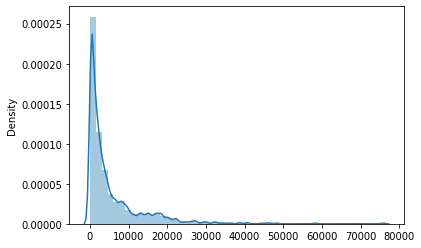

In [ ]:
sns.distplot(x=new_df.CompetitionDistance)

Competition Distance is positively skewed. Hence,Imputing NAN Values of Competition Distance with Median 

In [ ]:
median_competitionDistance=np.median(new_df[~new_df.CompetitionDistance.isna()].CompetitionDistance)
median_competitionDistance=round(median_competitionDistance,2)
print('Mean of Competition Distance Variable is :',median_competitionDistance)

Mean of Competition Distance Variable is : 2330.0


In [ ]:
new_df['CompetitionDistance'].replace(to_replace=np.NaN,value=median_competitionDistance,inplace=True)
new_df[new_df['Store']==291]['CompetitionDistance'].unique() #Checking If Nan value is replaced or not

array([2330.])

##### 2. CompetitionOpenSinceMonth

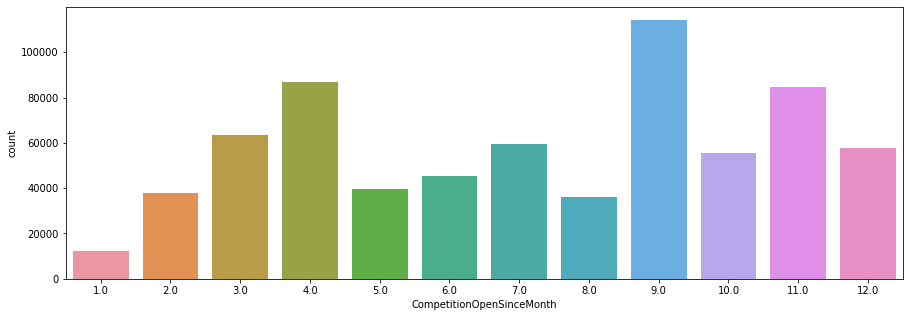

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
sns.countplot(x=new_df.CompetitionOpenSinceMonth)

In [ ]:
new_df.CompetitionOpenSinceMonth.value_counts()

9.0     114254
4.0      87076
11.0     84455
3.0      63548
7.0      59434
12.0     57896
10.0     55622
6.0      45444
5.0      39608
2.0      37886
8.0      36186
1.0      12452
Name: CompetitionOpenSinceMonth, dtype: int64

In [ ]:
len(new_df[new_df.CompetitionOpenSinceMonth.isna()])

323348

In [ ]:
temp_df=new_df[new_df.CompetitionOpenSinceMonth.isna()]
temp_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
10362,12,5,2015-07-31,8959,962,1,1,0,1,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
10363,12,4,2015-07-30,7996,835,1,1,0,1,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
10364,12,3,2015-07-29,9236,989,1,1,0,1,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
10365,12,2,2015-07-28,8822,861,1,1,0,1,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
10366,12,1,2015-07-27,10227,979,1,1,0,1,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [ ]:
new_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [ ]:
mode_CompetitionSinceMonth=stats.mode(new_df[~new_df.CompetitionOpenSinceMonth.isna()].CompetitionOpenSinceMonth)[0]
print('Mode of variable Competition Since Month is: ',mode_CompetitionSinceMonth)

Mode of variable Competition Since Month is:  [9.]


Imputing Competition Since month with Mode value

In [ ]:
new_df.CompetitionOpenSinceMonth.fillna(mode_CompetitionSinceMonth[0],inplace=True)

In [ ]:
new_df.CompetitionOpenSinceMonth.value_counts()

9.0     437602
4.0      87076
11.0     84455
3.0      63548
7.0      59434
12.0     57896
10.0     55622
6.0      45444
5.0      39608
2.0      37886
8.0      36186
1.0      12452
Name: CompetitionOpenSinceMonth, dtype: int64

##### 3. CompetitionOpenSinceYear

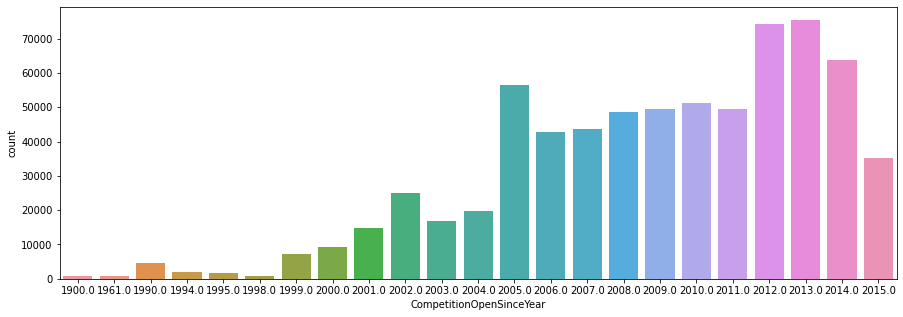

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
sns.countplot(x=new_df.CompetitionOpenSinceYear)

In [ ]:
new_df.CompetitionOpenSinceYear.value_counts()

2013.0    75426
2012.0    74299
2014.0    63732
2005.0    56564
2010.0    51258
2009.0    49396
2011.0    49396
2008.0    48476
2007.0    43744
2006.0    42802
2015.0    35060
2002.0    24882
2004.0    19804
2003.0    16794
2001.0    14704
2000.0     9236
1999.0     7352
1990.0     4710
1994.0     1884
1995.0     1700
1961.0      942
1998.0      942
1900.0      758
Name: CompetitionOpenSinceYear, dtype: int64

In [ ]:
len(new_df[new_df['CompetitionOpenSinceYear'].isna()])

323348

CompetitionsinceYear is also a discrete variable. Imputing the NaN values with Mode

In [ ]:
mode_CompetitionSinceYear=stats.mode(new_df[~new_df.CompetitionOpenSinceYear.isna()].CompetitionOpenSinceYear)[0][0]
print('Mode of variable Competition Since Year is: ',mode_CompetitionSinceYear)

Mode of variable Competition Since Year is:  2013.0


In [ ]:
new_df.CompetitionOpenSinceYear.fillna(mode_CompetitionSinceYear,inplace=True)

In [ ]:
new_df.CompetitionOpenSinceYear.value_counts()

2013.0    398774
2012.0     74299
2014.0     63732
2005.0     56564
2010.0     51258
2009.0     49396
2011.0     49396
2008.0     48476
2007.0     43744
2006.0     42802
2015.0     35060
2002.0     24882
2004.0     19804
2003.0     16794
2001.0     14704
2000.0      9236
1999.0      7352
1990.0      4710
1994.0      1884
1995.0      1700
1961.0       942
1998.0       942
1900.0       758
Name: CompetitionOpenSinceYear, dtype: int64

##### 4. PromoInterval

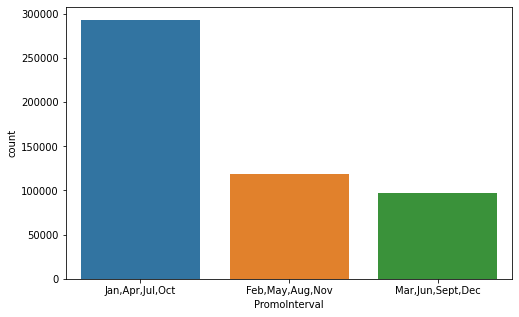

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
sns.countplot(x=new_df.PromoInterval)

In [ ]:
new_df.PromoInterval.unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [ ]:
new_df.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     293122
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: PromoInterval, dtype: int64

In [ ]:
len(new_df[new_df['PromoInterval'].isna()])

508031

In [ ]:
mode_promoInterval=stats.mode(new_df.PromoInterval)[0][0]
print('Mode of variable PromoInterval is: ',mode_promoInterval)

Mode of variable PromoInterval is:  Jan,Apr,Jul,Oct


Imputing PromoInterval with Mode

In [ ]:
new_df.PromoInterval.fillna(mode_promoInterval,inplace=True)

In [ ]:
new_df.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     801153
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: PromoInterval, dtype: int64

##### 4. Promo2SinceWeek and Promo2SinceYear

In [ ]:
len(new_df[new_df['Promo2SinceWeek'].isna()])

508031

In [ ]:
len(new_df[new_df['Promo2SinceYear'].isna()])

508031

In [ ]:
new_df[new_df['Promo2']==0 & new_df['Promo2SinceWeek'].isna() & new_df['Promo2SinceYear'].isna()]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016262,1114,6,2013-01-05,18856,3065,1,0,0,0,a,c,870.0,9.0,2013.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
1016263,1114,5,2013-01-04,18371,3036,1,0,0,1,a,c,870.0,9.0,2013.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
1016264,1114,4,2013-01-03,18463,3211,1,0,0,1,a,c,870.0,9.0,2013.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
1016265,1114,3,2013-01-02,20642,3401,1,0,0,1,a,c,870.0,9.0,2013.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"


In [ ]:
new_df[new_df['Promo2']==1 & new_df['Promo2SinceWeek'].isna() & new_df['Promo2SinceYear'].isna()]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


From above two results we can make that Promo2SinceWeek & Promo2SinceYear has NaN value wherever Promo2 has 0 value. Hence, we can impute these two columns with value as 0

In [ ]:
new_df.Promo2SinceWeek.fillna(0,inplace=True)
new_df.Promo2SinceYear.fillna(0,inplace=True)

##### Verifying If all the Nan values are imputes in this dataset

In [ ]:
list_NaNcols=Find_Null_Values(new_df)
list_NaNcols

[]

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1017209 no

## <u>**Handling Outliers**</u>

In [ ]:
categorical_variables=new_df.describe(include='object').columns.tolist()
categorical_variables

['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']

In [ ]:
numeric_variables = [var for var in new_df.columns if new_df[var].dtype!='O' and new_df[var].dtype!='<M8[ns]']
print('There are {} numerical variables'.format(len(numeric_variables)))

There are 13 numerical variables


In [ ]:
discrete_variables = []
for var in numeric_variables:
    if len(new_df[var].unique())<=1115:
        discrete_variables.append(var)
        
print('There are {} discrete variables'.format(len(discrete_variables)))

There are 11 discrete variables


In [ ]:
continuous_variables=[cols for cols in numeric_variables if cols not in discrete_variables]
continuous_variables

['Sales', 'Customers']

Out of 13 Numerical Variables in Dataset only 2 are continuous in Nature and rest 11 are discrete variables

### <u>Outlier Treatment of Continuos Variables</u>

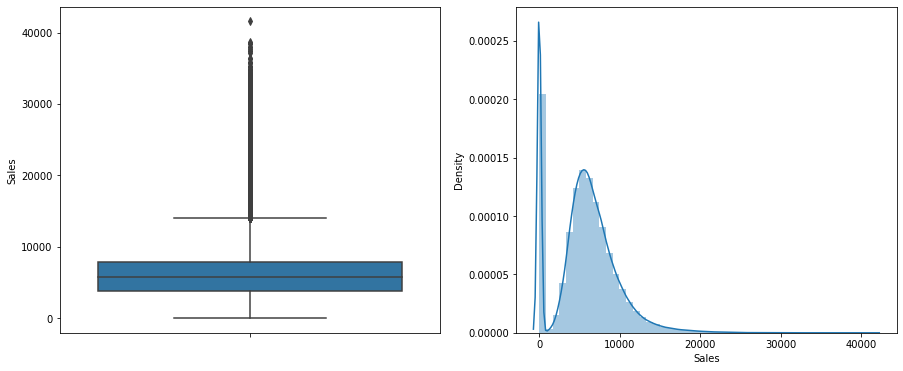

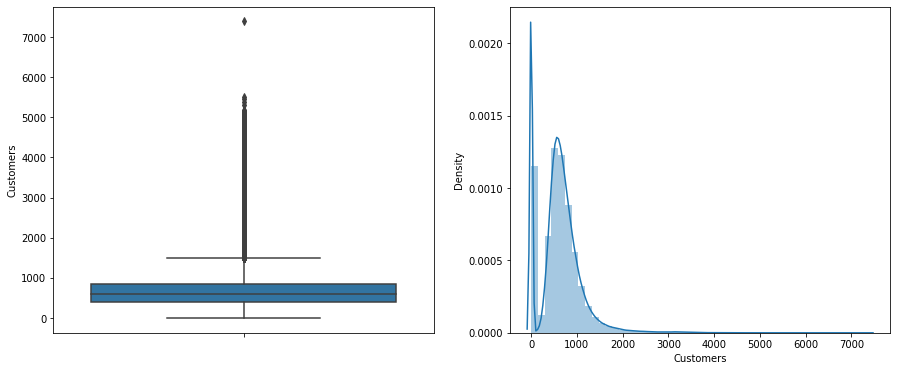

In [ ]:
for var in continuous_variables:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.boxplot(y=new_df[var])
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = sns.distplot(new_df[var])
    fig.set_xlabel(var)

    plt.show()

From the graphs above we can make that Both Customers and Sales follow same kind of distribution and Outliers Behavior is also same for both the variables.

Looks like During a particular Month Sales increases drastically with Customers So data is actually valid and there are no outliers. But we can remove the data point where Sales is greater than 40000 and Customers are greater than 7000

### Removing Extreme Data point of Sales Column

In [ ]:
index=new_df[new_df.Sales>40000.0].index
index

Int64Index([827591], dtype='int64')

In [ ]:
new_df.drop(inplace=True,index=index)

In [ ]:
new_df[new_df.Sales>40000.0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


### Removing Extreme Data Point of Customers Column

In [ ]:
new_df[new_df.Customers>7000]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
744384,817,2,2013-01-22,27190,7388,1,1,0,0,a,a,140.0,3.0,2006.0,0,0.0,0.0,"Jan,Apr,Jul,Oct"


In [ ]:
index=new_df[new_df.Customers>7000].index
index

Int64Index([744384], dtype='int64')

In [ ]:
new_df.drop(inplace=True,index=index)

In [ ]:
new_df[new_df.Customers>7000]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


### IQR Of Continuous(Customer and Sales) Variables

In [ ]:
#Sales
upper_lim = new_df['Sales'].quantile(.95)
print(upper_lim)
lower_lim = new_df['Sales'].quantile(.05)
print(lower_lim)

12136.699999999953
0.0


In [ ]:
#Customer
upper_lim = new_df['Customers'].quantile(.95)
print(upper_lim)
lower_lim = new_df['Customers'].quantile(.05)
print(lower_lim)

1362.0
0.0


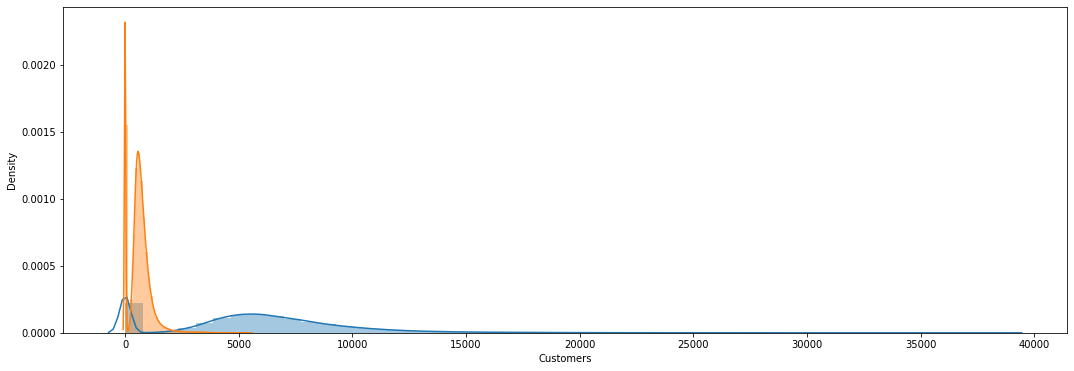

In [ ]:
plt.figure(figsize=(18,6))
sns.distplot(new_df.Sales)
sns.distplot(new_df.Customers)

## <b><u>Exploratory Data Analysis & Feature Engineering</u></b>

In [ ]:
new_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


### **Data Visualization of Variables**

In [ ]:
categorical_variables=new_df.describe(include=['object']).columns.tolist()
print('Categorical Variables are: ',categorical_variables)
num_var=new_df.describe().columns.tolist()
numeric_variables=[i for i in num_var if i!='Sales']
print('Numeric Variables are: ',numeric_variables)
datetime_variable=['Date']
print('DateTime Variable is: ',datetime_variable)

Categorical Variables are:  ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
Numeric Variables are:  ['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear']
DateTime Variable is:  ['Date']


In [ ]:
dependent_variable=['Sales']
independent_Variables=[cols for cols in new_df.columns if cols not in dependent_variable]
print(independent_Variables)

['Store', 'DayOfWeek', 'Date', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']


Create a histogram of Discrete Variables and Scatter plot for Continuous variables. 
Create striplot for Categorical variables.
In the same thing below we can add if condition if i is discrete then certain plot Strip plot and if Customers then Scatter plot. 

Dist plot by removing Closed parameter

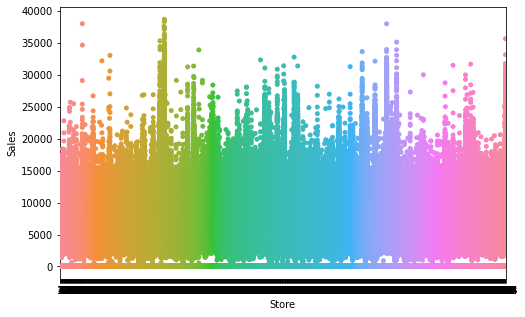

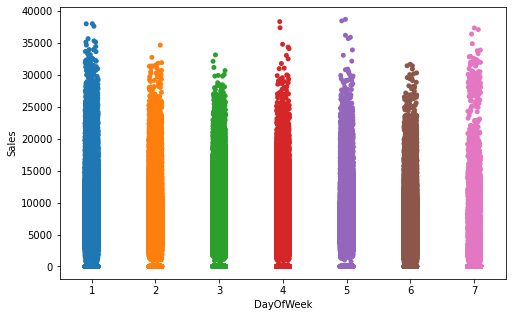

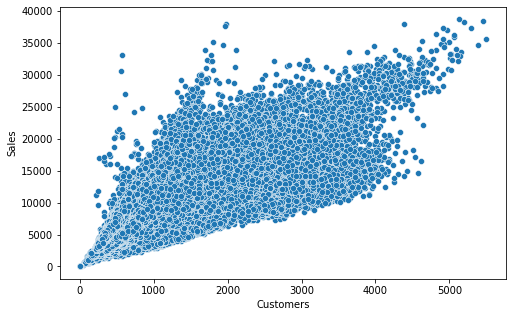

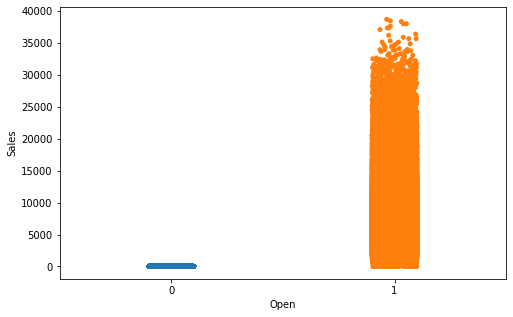

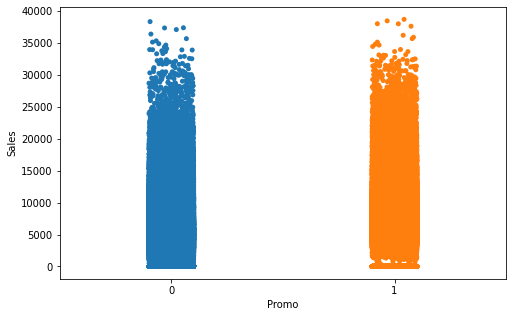

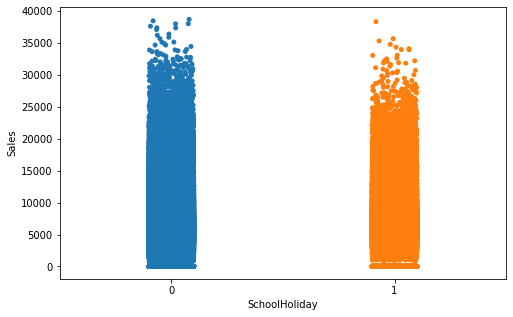

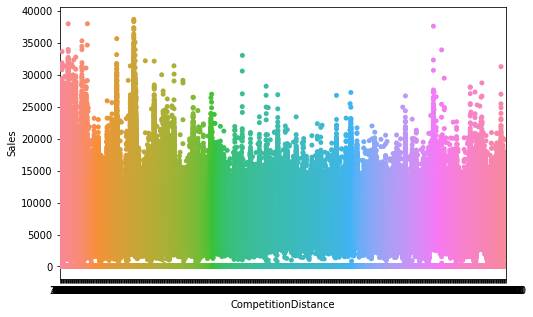

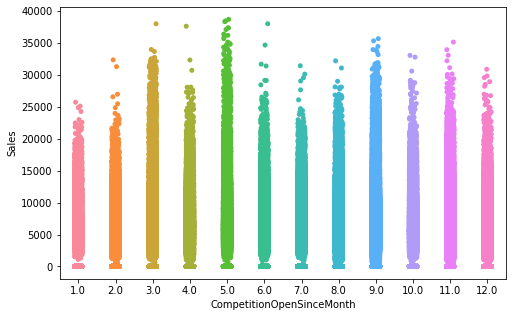

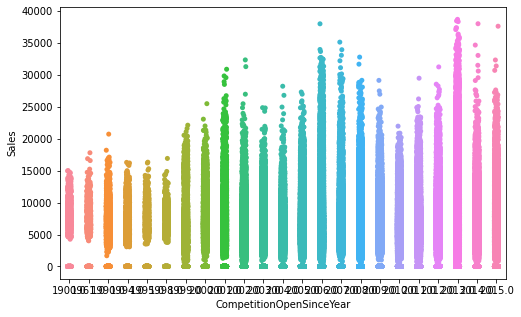

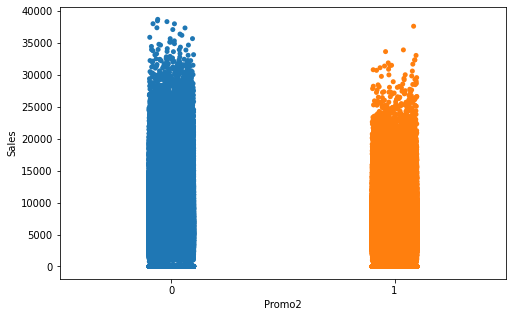

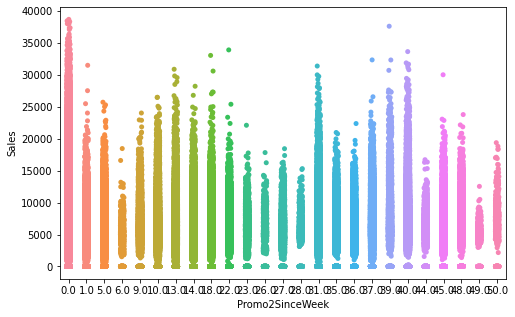

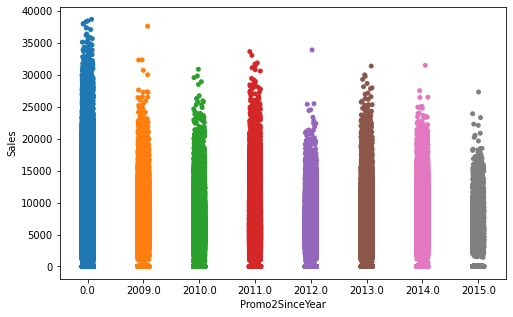

In [ ]:
for i in numeric_variables:
  if i in discrete_variables:
    sns.stripplot(x=new_df[i],y=new_df[dependent_variable[0]])
    plt.show()
  if i in continuous_variables:
    sns.scatterplot(x=new_df[i],y=new_df[dependent_variable[0]])
    plt.show()  

```
Conclusion from above plots: 

1. Sales are strongly dependent on Customers. 
2. Sales are 0 when Stores are closed which is an intuitive result.
3. Sales are almost similar whether or not Promo and Promo2 is applied.
 There isn't considerable amount of increase in sales when Promo and Promo2 is applied as compared to when it is not applied.
4. School Holiday is not impacting Sales as in both the cases there is almost similar number of Sales made.
```




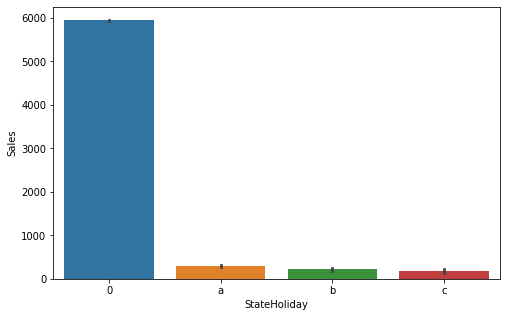

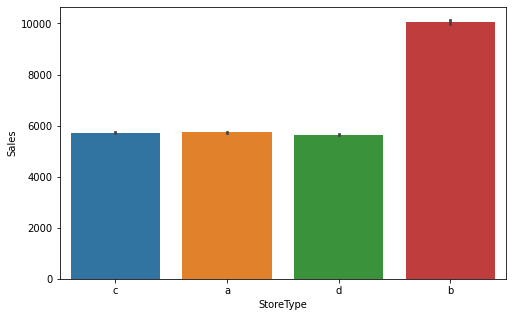

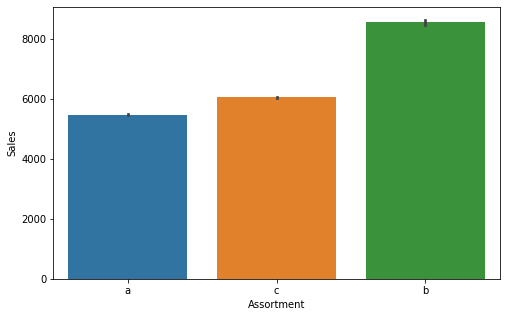

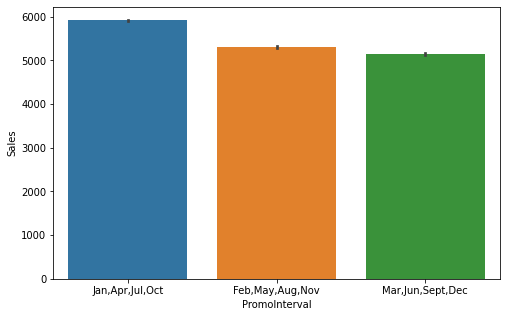

In [ ]:
for i in categorical_variables:
  sns.barplot(x=new_df[i],y=new_df['Sales'])
  plt.show()

```
Conclusion from above Bar plots:

1. Sales are pretty higher when there isn't a State Holiday
2. In other Categorical variables,Equivalent Sales is getting generated from all categories in each categorical variable.
```



#### <u>Visualization of Distribution of Sales and Customers when Store is Open</u>



In [ ]:
len(new_df[new_df.Open==0])

172817

In [ ]:
len(new_df[new_df.Open==1])

844390

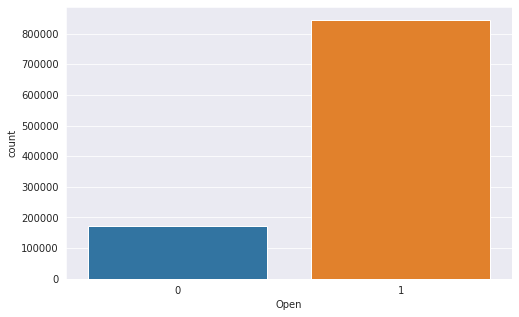

In [ ]:
sns.countplot(new_df.Open)

`If we are to predict Sales from different stores then Open is an important factor to derive that Sales would be 0 or greater than 0 So it is equally important for a model to know which Stores are open to contribute to the Sales and which one would be closed` 



Text(0.5, 1.0, 'Distribution Plot of Sales when Store is Open')

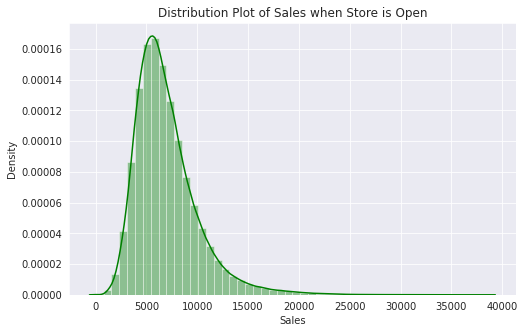

In [ ]:
sns.set_style(style='darkgrid')
sns.distplot(new_df[new_df.Open==1]['Sales'],color='green')
plt.title('Distribution Plot of Sales when Store is Open')

Text(0.5, 1.0, 'Distribution Plot of Customers when Store is Open')

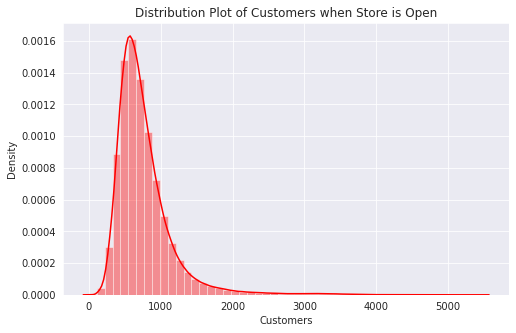

In [ ]:
sns.set_style(style='darkgrid')
sns.distplot(new_df[new_df.Open==1]['Customers'],color='red')
plt.title('Distribution Plot of Customers when Store is Open')

Customers and Sales follow same kind Guassian distribution 

#### <u>Collinearity Visualization</u>

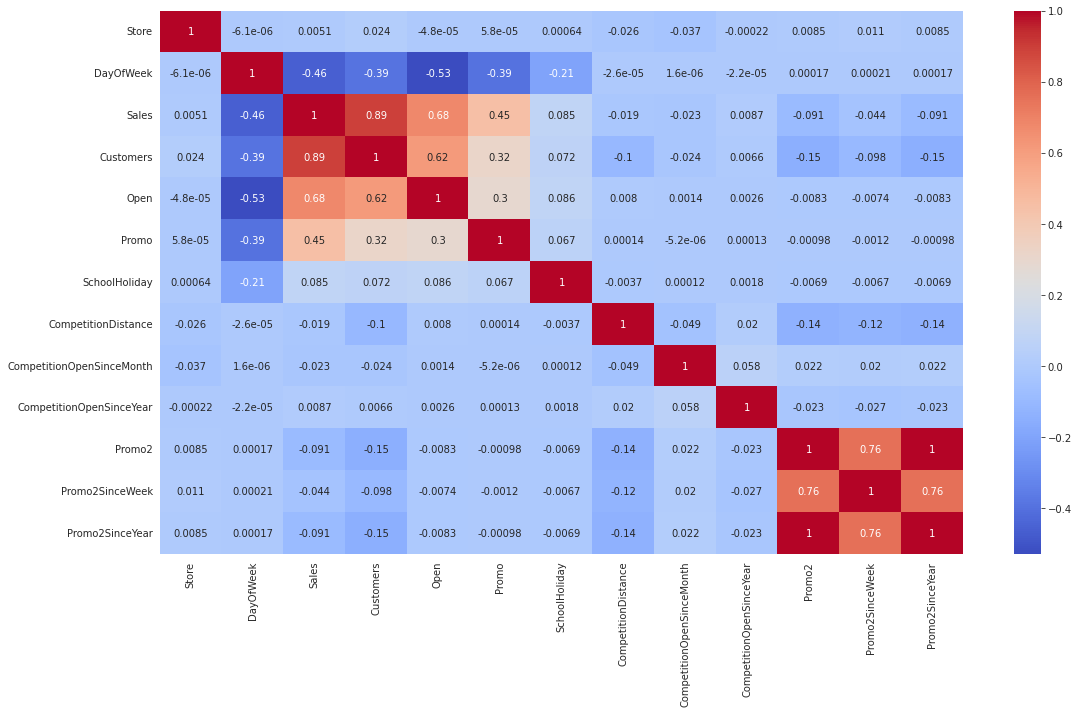

In [ ]:
plt.figure(figsize=(18,10))
# features=numeric_variables.append('Sales')
correlation=new_df[new_df.describe().columns.tolist()].corr()
sns.heatmap(correlation,cmap='coolwarm',annot=True)

### **Calculating VIF**

In [ ]:
#Creating a method tomcalculate VIF
def calculate_vif(x):
  vif = pd.DataFrame()
  vif["variables"] = x.columns
  vif["VIF"] = [round(variance_inflation_factor(x.values, i),3) for i in range(x.shape[1])]
  return(vif)

In [ ]:
calculate_vif(new_df[numeric_variables])

,variables,VIF
0,Store,4.025
1,DayOfWeek,7.881
2,Customers,5.112
3,Open,11.534
4,Promo,1.991
5,SchoolHoliday,1.272
6,CompetitionDistance,1.581
7,CompetitionOpenSinceMonth,8.912
8,CompetitionOpenSinceYear,35.996
9,Promo2,1565819.227


In [ ]:
new_df[(new_df['Promo2']!=0) & (new_df['Promo2SinceWeek']==0.0) & (new_df['Promo2SinceYear']==0.0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


Promo2 and Promo2SinceYear are highly correlated. Intuitively and from above results if Promo2 is 0 then corresponding Promo2SinceWeek and Promo2SinceYear are zero so we can drop off the column Promo2

In [ ]:
new_df.drop(columns='Promo2',axis=1,inplace=True)

In [ ]:
num_var=new_df.describe().columns.tolist()
numeric_variables=[i for i in num_var if i!='Sales']
calculate_vif(new_df[numeric_variables])

,variables,VIF
0,Store,4.022
1,DayOfWeek,7.881
2,Customers,5.110
3,Open,11.533
4,Promo,1.991
5,SchoolHoliday,1.272
6,CompetitionDistance,1.575
7,CompetitionOpenSinceMonth,8.911
8,CompetitionOpenSinceYear,35.995
9,Promo2SinceWeek,3.729


From the above Heatmap we can conclude that CompetitionSinceYear is not correlated to Sales (dependent variable) so we can drop off this variable. 

In [ ]:
features_to_exclude=['CompetitionOpenSinceYear']
features=[i for i in numeric_variables if i not in features_to_exclude]
calculate_vif(new_df[features])

,variables,VIF
0,Store,3.642
1,DayOfWeek,4.221
2,Customers,5.071
3,Open,8.909
4,Promo,1.912
5,SchoolHoliday,1.235
6,CompetitionDistance,1.524
7,CompetitionOpenSinceMonth,6.817
8,Promo2SinceWeek,3.729
9,Promo2SinceYear,4.791


### <u>**Feature Encoding**</u>
Encoding Categorical Variables - One Hot Encoding

##### State Holiday

Imputing Categorical State Holiday Type with One Hot encoding

In [ ]:
analysis_df=pd.DataFrame(new_df.StateHoliday.value_counts())

In [ ]:
analysis_df.index.tolist()

['0', 'a', 'b', 'c']

In [ ]:
new_df.StateHoliday=new_df.StateHoliday.map({0:0,'0':0,'a':1,'b':2,'c':3})

In [ ]:
new_df.StateHoliday.value_counts()

0    986157
1     20260
2      6690
3      4100
Name: StateHoliday, dtype: int64

##### Store Type

Creating Dummies of Store Type

In [ ]:
new_df.StoreType.unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [ ]:
one_hot=pd.get_dummies(new_df.StoreType,prefix='IsStoreType',drop_first=True)
one_hot.head()

,IsStoreType_b,IsStoreType_c,IsStoreType_d
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [ ]:
new_df.drop('StoreType',axis=1,inplace=True)
new_df=new_df.join(one_hot)
new_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,PromoInterval,IsStoreType_b,IsStoreType_c,IsStoreType_d
0,1,5,2015-07-31,5263,555,1,1,0,1,a,1270.0,9.0,2008.0,0.0,0.0,"Jan,Apr,Jul,Oct",0,1,0
1,1,4,2015-07-30,5020,546,1,1,0,1,a,1270.0,9.0,2008.0,0.0,0.0,"Jan,Apr,Jul,Oct",0,1,0
2,1,3,2015-07-29,4782,523,1,1,0,1,a,1270.0,9.0,2008.0,0.0,0.0,"Jan,Apr,Jul,Oct",0,1,0
3,1,2,2015-07-28,5011,560,1,1,0,1,a,1270.0,9.0,2008.0,0.0,0.0,"Jan,Apr,Jul,Oct",0,1,0
4,1,1,2015-07-27,6102,612,1,1,0,1,a,1270.0,9.0,2008.0,0.0,0.0,"Jan,Apr,Jul,Oct",0,1,0


In [ ]:
new_df[one_hot.columns.tolist()]=new_df[one_hot.columns.tolist()].astype('int')

##### Assortment

In [ ]:
new_df.Assortment.value_counts()

a    537444
c    471469
b      8294
Name: Assortment, dtype: int64

One Hot Encoding of this Categorical varaiable

In [ ]:
new_df.Assortment=new_df.Assortment.map({'a':1,'b':2,'c':3})
new_df.Assortment.value_counts()

1    537444
3    471469
2      8294
Name: Assortment, dtype: int64

##### PromoInterval

In [ ]:
new_df.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     801152
Feb,May,Aug,Nov     118595
Mar,Jun,Sept,Dec     97460
Name: PromoInterval, dtype: int64

In [ ]:
one_hot2=pd.get_dummies(new_df.PromoInterval,prefix='IsPromoInterval',drop_first=True)
new_df=new_df.join(one_hot2)
new_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,PromoInterval,IsStoreType_b,IsStoreType_c,IsStoreType_d,"IsPromoInterval_Jan,Apr,Jul,Oct","IsPromoInterval_Mar,Jun,Sept,Dec"
0,1,5,2015-07-31,5263,555,1,1,0,1,1,1270.0,9.0,2008.0,0.0,0.0,"Jan,Apr,Jul,Oct",0,1,0,1,0
1,1,4,2015-07-30,5020,546,1,1,0,1,1,1270.0,9.0,2008.0,0.0,0.0,"Jan,Apr,Jul,Oct",0,1,0,1,0
2,1,3,2015-07-29,4782,523,1,1,0,1,1,1270.0,9.0,2008.0,0.0,0.0,"Jan,Apr,Jul,Oct",0,1,0,1,0
3,1,2,2015-07-28,5011,560,1,1,0,1,1,1270.0,9.0,2008.0,0.0,0.0,"Jan,Apr,Jul,Oct",0,1,0,1,0
4,1,1,2015-07-27,6102,612,1,1,0,1,1,1270.0,9.0,2008.0,0.0,0.0,"Jan,Apr,Jul,Oct",0,1,0,1,0


In [ ]:
new_df[one_hot2.columns.tolist()]=new_df[one_hot2.columns.tolist()].astype('int')

In [ ]:
new_df.drop('PromoInterval',axis=1,inplace=True)

### **Creating New Features**

#### Extracting Day, year and month from date column to analyze indivisually

In [ ]:
new_df['Month']=new_df.Date.dt.month

In [ ]:
new_df['Year']=new_df.Date.dt.year

In [ ]:
new_df['Day']=new_df.Date.dt.day

In [ ]:
new_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,IsStoreType_b,IsStoreType_c,IsStoreType_d,"IsPromoInterval_Jan,Apr,Jul,Oct","IsPromoInterval_Mar,Jun,Sept,Dec",Month,Year,Day
0,1,5,2015-07-31,5263,555,1,1,0,1,1,1270.0,9.0,2008.0,0.0,0.0,0,1,0,1,0,7,2015,31
1,1,4,2015-07-30,5020,546,1,1,0,1,1,1270.0,9.0,2008.0,0.0,0.0,0,1,0,1,0,7,2015,30
2,1,3,2015-07-29,4782,523,1,1,0,1,1,1270.0,9.0,2008.0,0.0,0.0,0,1,0,1,0,7,2015,29
3,1,2,2015-07-28,5011,560,1,1,0,1,1,1270.0,9.0,2008.0,0.0,0.0,0,1,0,1,0,7,2015,28
4,1,1,2015-07-27,6102,612,1,1,0,1,1,1270.0,9.0,2008.0,0.0,0.0,0,1,0,1,0,7,2015,27


In [ ]:
new_df.drop(columns='Date',inplace=True)

## <u>**Creating Test Train Split for Modelling**</u>

In [ ]:
independent_features=[i for i in new_df.describe(include='all').columns.tolist() if (i not in features_to_exclude)]
independent_features.remove('Sales')
independent_features

['Store',
 'DayOfWeek',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'IsStoreType_b',
 'IsStoreType_c',
 'IsStoreType_d',
 'IsPromoInterval_Jan,Apr,Jul,Oct',
 'IsPromoInterval_Mar,Jun,Sept,Dec',
 'Month',
 'Year',
 'Day']

In [ ]:
x=new_df[independent_features]
y=new_df['Sales']

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=True)

In [ ]:
len(x_train),len(x_test)

(813765, 203442)

## <u>**Linear Regression Model**</u>

In [ ]:
regressor=LinearRegression()
regressor.fit(x_train,y_train)

LinearRegression()

In [ ]:
regressor.intercept_

-293074.1425334311

In [ ]:
regressor.coef_

array([-1.16501443e-01, -4.38611697e+01,  7.22538867e+00,  9.13978774e+02,
        1.11459677e+03, -2.76218091e+02,  4.01603049e+01,  1.28998539e+02,
        2.04051450e-02, -1.08865358e+01,  7.60671941e+00,  4.81562142e-02,
       -5.29025835e+03, -9.35946794e+01,  9.23679376e+02,  7.46980695e+01,
       -1.43814469e+02,  3.24399721e+01,  1.45231253e+02,  1.71324058e+00])

In [ ]:
y_pred_train=regressor.predict(x_train)

In [ ]:
y_pred_test=regressor.predict(x_test)

### **<u>Performance Metric</u>**

In [ ]:
performance_metric=pd.DataFrame(columns=['Model','MSE','RMSE','MAE','MAPE','R2','AdjustedR2'])

In [ ]:
def MeanNRootSquaredError(y_actual,y_predicted):
  ''' This method would return Mean Squared Error 
  and Root Mean Squared Error'''
  MSE  = round(mean_squared_error(y_actual,y_predicted),5)
  print("MSE :" , MSE)

  RMSE = np.sqrt(MSE)
  print("RMSE :" ,RMSE)
  return {'MSE':MSE,'RMSE':RMSE}

In [ ]:
def r2NAdjustedr2(y_actual,y_predicted,x):
  '''This method would return R2 Score and 
  Adjusted R2 score'''
  r2 = round(r2_score(y_actual,y_predicted),5)
  print("R2 :" ,r2)
  
  adjustedr2=1-(1-r2_score(y_actual, y_predicted))*((x.shape[0]-1)/(x.shape[0]-x.shape[1]-1))
  print("Adjusted R2 : ",round(adjustedr2,5))
  return {'R2':r2,'AdjustedR2':round(adjustedr2,5)}

In [ ]:
def meanAbsoluteNPercentageError(y_actual,y_predicted):
  '''This method would return Mean Absolute Error 
  and Mean Absolute Percentage Error'''
  MAE=round(mean_absolute_error(y_actual,y_predicted),5)
  print("MAE is: ",MAE)

  MAPE=round(mean_absolute_percentage_error(y_actual,y_predicted),5)
  print("MAPE is: ",MAPE)
  return {'MAE':MAE,'MAPE':MAPE}

In [ ]:
linear_model_per_dict={'Model':'Linear Regression'}

In [ ]:
print('MSE AND RMSE OF TRAINING SET')
MeanNRootSquaredError(y_train,y_pred_train)

print('--'*16)

print('MSE AND RMSE OF TEST SET')
linear_model_per_dict.update(MeanNRootSquaredError(y_test,y_pred_test))

MSE AND RMSE OF TRAINING SET
MSE : 1540724.7067
RMSE : 1241.2593229055724
--------------------------------
MSE AND RMSE OF TEST SET
MSE : 1533147.63819
RMSE : 1238.2033912851314


In [ ]:
print('R2 AND ADJUSTED R2 SCORE OF TRAINING SET')
r2NAdjustedr2(y_train,y_pred_train,x_train)

print('--'*16)

print('R2 AND ADJUSTED R2 SCORE OF TEST SET')
linear_model_per_dict.update(r2NAdjustedr2(y_test,y_pred_test,x_test))

R2 AND ADJUSTED R2 SCORE OF TRAINING SET
R2 : 0.89608
Adjusted R2 :  0.89608
--------------------------------
R2 AND ADJUSTED R2 SCORE OF TEST SET
R2 : 0.89639
Adjusted R2 :  0.89638


In [ ]:
print('MAE AND MAPE OF TRAINING SET')
meanAbsoluteNPercentageError(y_train,y_pred_train)

print('--'*16)

print('MAE AND MAPE OF TEST SET')
linear_model_per_dict.update(meanAbsoluteNPercentageError(y_test,y_pred_test))

MAE AND MAPE OF TRAINING SET
MAE is:  881.472
MAPE is:  4.1201253249285766e+17
--------------------------------
MAE AND MAPE OF TEST SET
MAE is:  880.68756
MAPE is:  4.086607420310696e+17


In [ ]:
performance_metric=performance_metric.append(pd.DataFrame(linear_model_per_dict,index=[0]))
performance_metric

,Model,MSE,RMSE,MAE,MAPE,R2,AdjustedR2
0,Linear Regression,1.533148e+06,1238.203391,880.68756,4.086607e+17,0.89639,0.89638


## <u>**Ridge Regression**</u>

In [ ]:
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=4)
ridge_regressor.fit(x_train,y_train)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20, 100]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_regressor.best_estimator_

Ridge(alpha=1)

In [ ]:
ridge_regressor.best_params_

{'alpha': 1}

In [ ]:
ridge_regressor.best_score_

-1540870.0338262809

In [ ]:
y_pred_train_ridge=ridge_regressor.predict(x_train)
y_pred_test_ridge=ridge_regressor.predict(x_test)

### <u>**Performance Metric**</u>

In [ ]:
ridge_model_per_dict={'Model':'Ridge Regression'}

In [ ]:
print('MSE AND RMSE OF TRAINING SET')
MeanNRootSquaredError(y_train,y_pred_train_ridge)

print('--'*16)

print('MSE AND RMSE OF TEST SET')
ridge_model_per_dict.update(MeanNRootSquaredError(y_test,y_pred_test_ridge))

MSE AND RMSE OF TRAINING SET
MSE : 1540724.71007
RMSE : 1241.2593242630646
--------------------------------
MSE AND RMSE OF TEST SET
MSE : 1533147.75844
RMSE : 1238.2034398433887


In [ ]:
print('R2 AND ADJUSTED R2 SCORE OF TRAINING SET')
r2NAdjustedr2(y_train,y_pred_train_ridge,x_train)

print('--'*16)

print('R2 AND ADJUSTED R2 SCORE OF TEST SET')
ridge_model_per_dict.update(r2NAdjustedr2(y_test,y_pred_test_ridge,x_test))

R2 AND ADJUSTED R2 SCORE OF TRAINING SET
R2 : 0.89608
Adjusted R2 :  0.89608
--------------------------------
R2 AND ADJUSTED R2 SCORE OF TEST SET
R2 : 0.89639
Adjusted R2 :  0.89638


In [ ]:
print('MAE AND MAPE OF TRAINING SET')
meanAbsoluteNPercentageError(y_train,y_pred_train_ridge)

print('--'*16)

print('MAE AND MAPE OF TEST SET')
ridge_model_per_dict.update(meanAbsoluteNPercentageError(y_test,y_pred_test_ridge))

MAE AND MAPE OF TRAINING SET
MAE is:  881.47152
MAPE is:  4.120095906458687e+17
--------------------------------
MAE AND MAPE OF TEST SET
MAE is:  880.68707
MAPE is:  4.0865780737397664e+17


In [ ]:
performance_metric=performance_metric.append(pd.DataFrame(ridge_model_per_dict,index=[1]))

In [ ]:
performance_metric

,Model,MSE,RMSE,MAE,MAPE,R2,AdjustedR2
0,Linear Regression,1.533148e+06,1238.203391,880.68756,4.086607e+17,0.89639,0.89638
1,Ridge Regression,1.533148e+06,1238.203440,880.68707,4.086578e+17,0.89639,0.89638


## **<u>Lasso Regression Model</u>**

In [ ]:
lasso=Lasso()
parameters = {'alpha': [1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,20,50,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-08, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 20, 50, 100]},
             scoring='neg_mean_squared_error')

In [ ]:
lasso_regressor.best_estimator_

Lasso(alpha=0.001)

In [ ]:
lasso_regressor.best_params_

{'alpha': 0.001}

In [ ]:
lasso_regressor.best_score_

-1540859.7674371551

In [ ]:
y_pred_train_lasso=lasso_regressor.predict(x_train)
y_pred_test_lasso=lasso_regressor.predict(x_test)

### **<u>Performance Metric</u>**

In [ ]:
lasso_model_per_dict={'Model':'Lasso Regression'}

In [ ]:
print('MSE AND RMSE OF TRAINING SET')
MeanNRootSquaredError(y_train,y_pred_train_lasso)

print('--'*16)

print('MSE AND RMSE OF TEST SET')
lasso_model_per_dict.update(MeanNRootSquaredError(y_test,y_pred_test_lasso))

MSE AND RMSE OF TRAINING SET
MSE : 1540724.70683
RMSE : 1241.2593229579386
--------------------------------
MSE AND RMSE OF TEST SET
MSE : 1533147.57566
RMSE : 1238.2033660348368


In [ ]:
print('R2 AND ADJUSTED R2 SCORE OF TRAINING SET')
r2NAdjustedr2(y_train,y_pred_train_lasso,x_train)

print('--'*16)

print('R2 AND ADJUSTED R2 SCORE OF TEST SET')
lasso_model_per_dict.update(r2NAdjustedr2(y_test,y_pred_test_lasso,x_test))

R2 AND ADJUSTED R2 SCORE OF TRAINING SET
R2 : 0.89608
Adjusted R2 :  0.89608
--------------------------------
R2 AND ADJUSTED R2 SCORE OF TEST SET
R2 : 0.89639
Adjusted R2 :  0.89638


In [ ]:
print('MAE AND MAPE OF TRAINING SET')
meanAbsoluteNPercentageError(y_train,y_pred_train_lasso)

print('--'*16)

print('MAE AND MAPE OF TEST SET')
lasso_model_per_dict.update(meanAbsoluteNPercentageError(y_test,y_pred_test_lasso))

MAE AND MAPE OF TRAINING SET
MAE is:  881.47153
MAPE is:  4.12010593011923e+17
--------------------------------
MAE AND MAPE OF TEST SET
MAE is:  880.68707
MAPE is:  4.086587896943022e+17


In [ ]:
performance_metric=performance_metric.append(pd.DataFrame(lasso_model_per_dict,index=[2]))

In [ ]:
performance_metric

,Model,MSE,RMSE,MAE,MAPE,R2,AdjustedR2
0,Linear Regression,1.533148e+06,1238.203391,880.68756,4.086607e+17,0.89639,0.89638
1,Ridge Regression,1.533148e+06,1238.203440,880.68707,4.086578e+17,0.89639,0.89638
2,Lasso Regression,1.533148e+06,1238.203366,880.68707,4.086588e+17,0.89639,0.89638


## <u>**Elastic Net Regression**</u>

In [ ]:
elastic = ElasticNet()
parameters = {'alpha': [1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100],'l1_ratio':[0.1,0.4,0.5,0.8]}
elastic_regressor = GridSearchCV(elastic, parameters, scoring='neg_mean_squared_error',cv=5)
elastic_regressor.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [1e-08, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 100],
                         'l1_ratio': [0.1, 0.4, 0.5, 0.8]},
             scoring='neg_mean_squared_error')

In [ ]:
elastic_regressor.best_estimator_

ElasticNet(alpha=1e-05, l1_ratio=0.8)

In [ ]:
elastic_regressor.best_params_

{'alpha': 1e-05, 'l1_ratio': 0.8}

In [ ]:
elastic_regressor.best_score_

-1540859.757759726

In [ ]:
y_pred_train_elastic=elastic_regressor.predict(x_train)
y_pred_test_elastic=elastic_regressor.predict(x_test)

### <u>**Performance Metric**</u>

In [ ]:
elastic_model_per_dict={'Model':'Elastic Regression'}

In [ ]:
print('MSE AND RMSE OF TRAINING SET')
MeanNRootSquaredError(y_train,y_pred_train_elastic)

print('--'*16)

print('MSE AND RMSE OF TEST SET')
elastic_model_per_dict.update(MeanNRootSquaredError(y_test,y_pred_test_elastic))

MSE AND RMSE OF TRAINING SET
MSE : 1540724.71564
RMSE : 1241.2593265067537
--------------------------------
MSE AND RMSE OF TEST SET
MSE : 1533147.83681
RMSE : 1238.2034714900456


In [ ]:
print('R2 AND ADJUSTED R2 SCORE OF TRAINING SET')
r2NAdjustedr2(y_train,y_pred_train_elastic,x_train)

print('--'*16)

print('R2 AND ADJUSTED R2 SCORE OF TEST SET')
elastic_model_per_dict.update(r2NAdjustedr2(y_test,y_pred_test_elastic,x_test))

R2 AND ADJUSTED R2 SCORE OF TRAINING SET
R2 : 0.89608
Adjusted R2 :  0.89608
--------------------------------
R2 AND ADJUSTED R2 SCORE OF TEST SET
R2 : 0.89639
Adjusted R2 :  0.89638


In [ ]:
print('MAE AND MAPE OF TRAINING SET')
meanAbsoluteNPercentageError(y_train,y_pred_train_elastic)

print('--'*16)

print('MAE AND MAPE OF TEST SET')
elastic_model_per_dict.update(meanAbsoluteNPercentageError(y_test,y_pred_test_elastic))

MAE AND MAPE OF TRAINING SET
MAE is:  881.47121
MAPE is:  4.120077291960474e+17
--------------------------------
MAE AND MAPE OF TEST SET
MAE is:  880.68676
MAPE is:  4.0865595036040134e+17


In [ ]:
performance_metric=performance_metric.append(pd.DataFrame(elastic_model_per_dict,index=[3]))

In [ ]:
performance_metric

,Model,MSE,RMSE,MAE,MAPE,R2,AdjustedR2
0,Linear Regression,1.533148e+06,1238.203391,880.68756,4.086607e+17,0.89639,0.89638
1,Ridge Regression,1.533148e+06,1238.203440,880.68707,4.086578e+17,0.89639,0.89638
2,Lasso Regression,1.533148e+06,1238.203366,880.68707,4.086588e+17,0.89639,0.89638
3,Elastic Regression,1.533148e+06,1238.203471,880.68676,4.086560e+17,0.89639,0.89638


## <u>**Decision Tree Regressor**</u>

In [ ]:
decisionTree=DecisionTreeRegressor()
params = {'max_leaf_nodes': [10,100,20,60], 'min_samples_split': [2, 3, 4]}
decisionTreeregressor = GridSearchCV(decisionTree, params, verbose=1, cv=3)
decisionTreeregressor.fit(x_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_leaf_nodes': [10, 100, 20, 60],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [ ]:
decisionTreeregressor.best_params_

{'max_leaf_nodes': 100, 'min_samples_split': 2}

In [ ]:
decisionTreeregressor.best_score_

0.9191315404783512

In [ ]:
y_train_pred_tree=decisionTreeregressor.predict(x_train)
y_test_pred_tree=decisionTreeregressor.predict(x_test)

### **Performance Metric**

In [ ]:
decision_model_per_dict={'Model':'Decision Tree Regressor'}

In [ ]:
print('MSE AND RMSE OF TRAINING SET')
MeanNRootSquaredError(y_train,y_train_pred_tree)

print('--'*16)

print('MSE AND RMSE OF TEST SET')
decision_model_per_dict.update(MeanNRootSquaredError(y_test,y_test_pred_tree))

MSE AND RMSE OF TRAINING SET
MSE : 1190456.05411
RMSE : 1091.0802234987123
--------------------------------
MSE AND RMSE OF TEST SET
MSE : 1193881.09375
RMSE : 1092.6486597941719


In [ ]:
print('R2 AND ADJUSTED R2 SCORE OF TRAINING SET')
r2NAdjustedr2(y_train,y_train_pred_tree,x_train)

print('--'*16)

print('R2 AND ADJUSTED R2 SCORE OF TEST SET')
decision_model_per_dict.update(r2NAdjustedr2(y_test,y_test_pred_tree,x_test))

R2 AND ADJUSTED R2 SCORE OF TRAINING SET
R2 : 0.9197
Adjusted R2 :  0.9197
--------------------------------
R2 AND ADJUSTED R2 SCORE OF TEST SET
R2 : 0.91932
Adjusted R2 :  0.91931


In [ ]:
print('MAE AND MAPE OF TRAINING SET')
meanAbsoluteNPercentageError(y_train,y_train_pred_tree)

print('--'*16)

print('MAE AND MAPE OF TEST SET')
decision_model_per_dict.update(meanAbsoluteNPercentageError(y_test,y_test_pred_tree))

MAE AND MAPE OF TRAINING SET
MAE is:  736.70746
MAPE is:  132562936857460.14
--------------------------------
MAE AND MAPE OF TEST SET
MAE is:  739.27568
MAPE is:  131876846359233.0


In [ ]:
performance_metric=performance_metric.append(pd.DataFrame(decision_model_per_dict,index=[4]))

In [ ]:
performance_metric

,Model,MSE,RMSE,MAE,MAPE,R2,AdjustedR2
0,Linear Regression,1.533148e+06,1238.203391,880.68756,4.086607e+17,0.89639,0.89638
1,Ridge Regression,1.533148e+06,1238.203440,880.68707,4.086578e+17,0.89639,0.89638
2,Lasso Regression,1.533148e+06,1238.203366,880.68707,4.086588e+17,0.89639,0.89638
3,Elastic Regression,1.533148e+06,1238.203471,880.68676,4.086560e+17,0.89639,0.89638
4,Decision Tree Regressor,1.193881e+06,1092.648660,739.27568,1.318768e+14,0.91932,0.91931


## <u>**XGBoost**</u>

In [ ]:
xgbRegressor = XGBRegressor()
# param_grid={'n_estimators':[100],'learning_rate':[0.001,0.01,0.1]}
# xgbRegressor=GridSearchCV(xgb,param_grid=param_grid,cv=3,verbose=3)
xgbRegressor.fit(x_train,y_train)

[06:15:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
xgbRegressor.feature_importances_

array([0.01316863, 0.02790182, 0.55121964, 0.        , 0.11632966,
       0.00124221, 0.001634  , 0.02329211, 0.02495995, 0.0115244 ,
       0.01772865, 0.00840859, 0.05339142, 0.00592867, 0.10574313,
       0.00305741, 0.        , 0.01866509, 0.00741005, 0.00839454],
      dtype=float32)

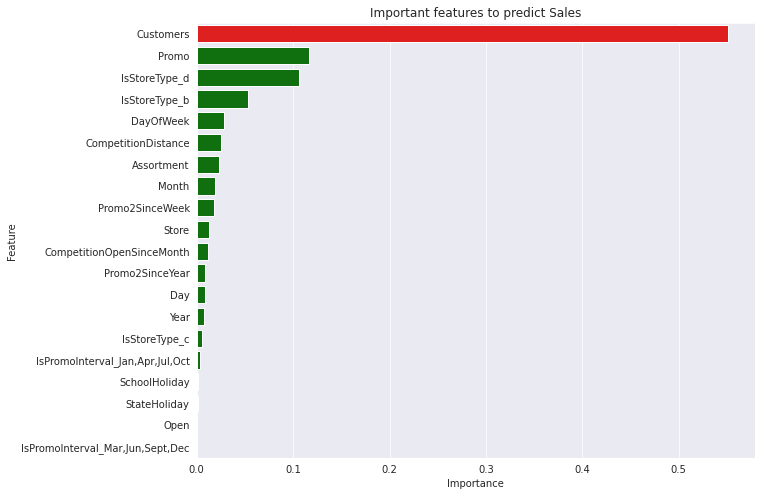

In [ ]:
feat_dict= {}
for col, val in sorted(zip(x_train.columns, xgbRegressor.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
values = feat_df.Importance    
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict Sales')
plt.show()

In [ ]:
y_pred_train_xgb=xgbRegressor.predict(x_train)
y_pred_test_xgb=xgbRegressor.predict(x_test)

### <u>**Performance Metric**</u>

In [ ]:
xgb_model_per_dict={'Model':'XGBoost Regressor'}

In [ ]:
print('MSE AND RMSE OF TRAINING SET')
MeanNRootSquaredError(y_train,y_pred_train_xgb)

print('--'*16)

print('MSE AND RMSE OF TEST SET')
xgb_model_per_dict.update(MeanNRootSquaredError(y_test,y_pred_test_xgb))

MSE AND RMSE OF TRAINING SET
MSE : 906149.12848
RMSE : 951.9186564407696
--------------------------------
MSE AND RMSE OF TEST SET
MSE : 904654.45089
RMSE : 951.1332456023183


In [ ]:
print('R2 AND ADJUSTED R2 SCORE OF TRAINING SET')
r2NAdjustedr2(y_train,y_pred_train_xgb,x_train)

print('--'*16)

print('R2 AND ADJUSTED R2 SCORE OF TEST SET')
xgb_model_per_dict.update(r2NAdjustedr2(y_test,y_pred_test_xgb,x_test))

R2 AND ADJUSTED R2 SCORE OF TRAINING SET
R2 : 0.93888
Adjusted R2 :  0.93888
--------------------------------
R2 AND ADJUSTED R2 SCORE OF TEST SET
R2 : 0.93887
Adjusted R2 :  0.93886


In [ ]:
print('MAE AND MAPE OF TRAINING SET')
meanAbsoluteNPercentageError(y_train,y_pred_train_xgb)

print('--'*16)

print('MAE AND MAPE OF TEST SET')
xgb_model_per_dict.update(meanAbsoluteNPercentageError(y_test,y_pred_test_xgb))

MAE AND MAPE OF TRAINING SET
MAE is:  662.15054
MAPE is:  1.2109858517542234e+17
--------------------------------
MAE AND MAPE OF TEST SET
MAE is:  662.95107
MAPE is:  1.1976715657499776e+17


In [ ]:
performance_metric=performance_metric.append(pd.DataFrame(xgb_model_per_dict,index=[5]))

In [ ]:
performance_metric

,Model,MSE,RMSE,MAE,MAPE,R2,AdjustedR2
0,Linear Regression,1.533148e+06,1238.203391,880.68756,4.086607e+17,0.89639,0.89638
1,Ridge Regression,1.533148e+06,1238.203440,880.68707,4.086578e+17,0.89639,0.89638
2,Lasso Regression,1.533148e+06,1238.203366,880.68707,4.086588e+17,0.89639,0.89638
3,Elastic Regression,1.533148e+06,1238.203471,880.68676,4.086560e+17,0.89639,0.89638
4,Decision Tree Regressor,1.193881e+06,1092.648660,739.27568,1.318768e+14,0.91932,0.91931
5,XGBoost Regressor,9.046545e+05,951.133246,662.95107,1.197672e+17,0.93887,0.93886


## <u>**Gradient Boosting**</u>

In [ ]:
gBoosting=GradientBoostingRegressor()
gBoosting.fit(x_train,y_train)

GradientBoostingRegressor()

In [ ]:
y_pred_train_gboost=gBoosting.predict(x_train)
y_pred_test_gboost=gBoosting.predict(x_test)

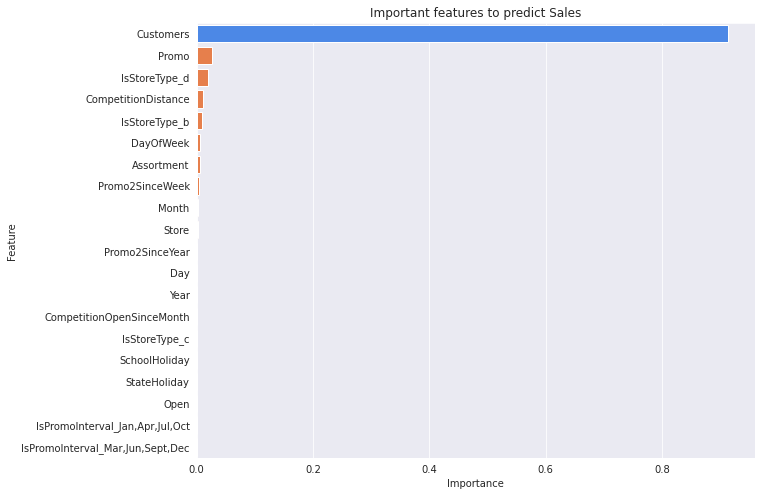

In [ ]:
feat_dict= {}
for col, val in sorted(zip(x_train.columns, gBoosting.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
values = feat_df.Importance    
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['#FF7733' if (x < max(values)) else '#3382FF' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict Sales')
plt.show()

### <u>Peformance Metric</u>

In [ ]:
gb_model_per_dict={'Model':'Gradient Boosting Regressor'}

In [ ]:
print('MSE AND RMSE OF TRAINING SET')
MeanNRootSquaredError(y_train,y_pred_train_xgb)

print('--'*16)

print('MSE AND RMSE OF TEST SET')
gb_model_per_dict.update(MeanNRootSquaredError(y_test,y_pred_test_gboost))

MSE AND RMSE OF TRAINING SET
MSE : 906149.12848
RMSE : 951.9186564407696
--------------------------------
MSE AND RMSE OF TEST SET
MSE : 904016.52305
RMSE : 950.7978350048974


In [ ]:
print('R2 AND ADJUSTED R2 SCORE OF TRAINING SET')
r2NAdjustedr2(y_train,y_pred_train_gboost,x_train)

print('--'*16)

print('R2 AND ADJUSTED R2 SCORE OF TEST SET')
gb_model_per_dict.update(r2NAdjustedr2(y_test,y_pred_test_gboost,x_test))

R2 AND ADJUSTED R2 SCORE OF TRAINING SET
R2 : 0.93888
Adjusted R2 :  0.93888
--------------------------------
R2 AND ADJUSTED R2 SCORE OF TEST SET
R2 : 0.93891
Adjusted R2 :  0.9389


In [ ]:
print('MAE AND MAPE OF TRAINING SET')
meanAbsoluteNPercentageError(y_train,y_pred_train_gboost)

print('--'*16)

print('MAE AND MAPE OF TEST SET')
gb_model_per_dict.update(meanAbsoluteNPercentageError(y_test,y_pred_test_gboost))

MAE AND MAPE OF TRAINING SET
MAE is:  662.19625
MAPE is:  1.208713529052403e+17
--------------------------------
MAE AND MAPE OF TEST SET
MAE is:  662.85177
MAPE is:  1.1953593761934992e+17


In [ ]:
performance_metric=performance_metric.append(pd.DataFrame(gb_model_per_dict,index=[6]))

In [ ]:
performance_metric

,Model,MSE,RMSE,MAE,MAPE,R2,AdjustedR2
0,Linear Regression,1.533148e+06,1238.203391,880.68756,4.086607e+17,0.89639,0.89638
1,Ridge Regression,1.533148e+06,1238.203440,880.68707,4.086578e+17,0.89639,0.89638
2,Lasso Regression,1.533148e+06,1238.203366,880.68707,4.086588e+17,0.89639,0.89638
3,Elastic Regression,1.533148e+06,1238.203471,880.68676,4.086560e+17,0.89639,0.89638
4,Decision Tree Regressor,1.193881e+06,1092.648660,739.27568,1.318768e+14,0.91932,0.91931
5,XGBoost Regressor,9.046545e+05,951.133246,662.95107,1.197672e+17,0.93887,0.93886
6,Gradient Boosting Regressor,9.040165e+05,950.797835,662.85177,1.195359e+17,0.93891,0.93890
